## 3. Purely Louvain Algorithm Implementation

In this notebook we apply the Louvain algorithm for community detection on a graph of video games. Each game is modeled as a node, and edges are weighted by the cosine similarity of their textual embeddings. To avoid very dense graphs, we keep only edges above a similarity threshold, so that connections reflect stronger semantic relationships (for example, in genre, narrative, or playstyle).

We explore different similarity thresholds and Louvain resolution parameters, which together control how the graph is constructed. For each configuration we compute quality metrics as modularity, Silhouette score, and Davies-Bouldin score; and combine them into a score that also takes into consideration the computational cost. We then inspect the resulting communities, also visually.

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import time
import community as community_louvain
import tracemalloc
from sklearn.metrics import silhouette_score, davies_bouldin_score
import random
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pickle

In [183]:
emb_norm = np.load("../data/embeddings_FINAL.npy") 
games_df = pd.read_pickle("../data/games_df_FINAL.pkl")

# print(emb_norm.shape)
# print(games_df.shape)

### 3.1 Construct Louvain's starting graph with weighted edges based in cosine similarity

In [184]:
# build a graph for a given threshold
def build_graph_from_sim(sim_matrix, threshold: float) -> nx.Graph:
    """
    Build an undirected graph where nodes are indices in sim_matrix
    and edges are added for similarities > threshold.
    """
    t0 = time.time()
    n = sim_matrix.shape[0]
    G = nx.Graph()
    G.add_nodes_from(range(n))

    # Vectorized: find all (i, j) with sim > threshold and i<j
    rows, cols = np.where(sim_matrix > threshold)
    mask = rows < cols
    rows, cols = rows[mask], cols[mask]

    for i, j in zip(rows, cols):
        G.add_edge(int(i), int(j), weight=float(sim_matrix[i, j]))
        
    print(
        f"Graph built: nodes={G.number_of_nodes()}, "
        f"edges={G.number_of_edges()}, "
        f"time={time.time() - t0:.2f}s"
    )

    return G

In [ ]:
# Create the cosine similarity matrix
t0 = time.time()
sim_matrix = cosine_similarity(emb_norm)
print("Cosine similarity done in:", time.time() - t0, "sec")

Cosine similarity done in: 1.0190174579620361 sec


### 3.2 Execute Louvain and analysis

#### 3.2.1 Code to run Louvain

In [ ]:
def evaluate_louvain(
    G: nx.Graph,
    embeddings: np.ndarray,
    resolution: float = 1.0,
    seed: int = 0,
) -> dict:
    """
    Run Louvain on graph G, compute:
    - modularity
    - #clusters, cluster sizes
    - silhouette, Davies-Bouldin on embeddings
    - runtime, peak memory
    Returns a dict of metrics.
    """
    # Measure memory + time
    tracemalloc.start()
    t0 = time.time()

    partition = community_louvain.best_partition(
        G,
        weight="weight",
        resolution=resolution,
        random_state=seed,
    )

    runtime = time.time() - t0
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    peak_mb = peak / (1024 ** 2)

    # Partition -> labels array aligned with node indices
    # nodes are 0..N-1, same as rows in embeddings
    labels = np.array([partition[i] for i in range(len(partition))])
    n_clusters = len(np.unique(labels))

    # Cluster size stats
    cluster_sizes = pd.Series(labels).value_counts()
    largest_cluster = int(cluster_sizes.max())
    smallest_cluster = int(cluster_sizes.min())

    # Modularity
    modularity = community_louvain.modularity(partition, G, weight="weight")

    # Silhouette / DB on embeddings (only if >1 cluster and not all singletons)
    try:
        if n_clusters > 1 and largest_cluster > 1:
            sil = silhouette_score(embeddings, labels)
            db = davies_bouldin_score(embeddings, labels)
        else:
            sil = np.nan
            db = np.nan
    except Exception as e:
        print("Metric error:", e)
        sil = np.nan
        db = np.nan

    return {
        "resolution": resolution,
        "seed": seed,
        "n_clusters": n_clusters,
        "largest_cluster": largest_cluster,
        "smallest_cluster": smallest_cluster,
        "modularity": modularity,
        "silhouette": sil,
        "davies_bouldin": db,
        "runtime_sec": runtime,
        "peak_mem_mb": peak_mb,
    }, partition


#### 3.2.2 Grid search of best configuration for Louvain with different thresholds and resolutions

In [194]:
thresholds = [0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85]
resolutions = [0.5, 1.0, 1.5]
seeds = [0]

results = []
partitions_cache = {}  # key: (thr, res, seed) -> partition

for thr in thresholds:
    print(f"\n=== Threshold {thr} ===")
    G_thr = build_graph_from_sim(sim_matrix, thr)
    
    for res in resolutions:
        for seed in seeds:
            print(f"  -> Louvain: res={res}, seed={seed}")
            metrics, partition = evaluate_louvain(
                G_thr,
                emb_norm,
                resolution=res,
                seed=seed,
            )
            metrics_with_thr = {"threshold": thr, **metrics}
            results.append(metrics_with_thr)
            partitions_cache[(thr, res, seed)] = partition

results_df = pd.DataFrame(results)


=== Threshold 0.4 ===
Graph built: nodes=10476, edges=3010936, time=8.13s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.5 ===
Graph built: nodes=10476, edges=426116, time=2.97s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.6 ===
Graph built: nodes=10476, edges=63942, time=0.58s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.65 ===
Graph built: nodes=10476, edges=27442, time=0.63s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.7 ===
Graph built: nodes=10476, edges=11714, time=0.40s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.75 ===
Graph built: nodes=10476, edges=5075, time=0.40s
  -> Louvain: res=0.5, seed=0
  -> Louvain: res=1.0, seed=0
  -> Louvain: res=1.5, seed=0

=== Threshold 0.8

In [279]:
results_df

,threshold,resolution,seed,n_clusters,largest_cluster,smallest_cluster,modularity,silhouette,davies_bouldin,runtime_sec,peak_mem_mb
0,0.40,0.5,0,357,6261,1,0.189876,-0.092461,1.234882,90.096862,759.169371
1,0.40,1.0,0,20,3262,1,0.284516,0.017489,1.969184,214.781497,758.755286
2,0.40,1.5,0,42,1954,1,0.260726,-0.105735,2.196742,217.446539,758.884832
3,0.50,0.5,0,931,4816,1,0.446915,-0.048380,1.255729,16.582748,112.161957
4,0.50,1.0,0,597,3176,1,0.483272,-0.077570,1.048565,81.297353,112.185759
5,0.50,1.5,0,602,2082,1,0.467201,-0.064767,1.088848,35.234539,112.235258
6,0.60,0.5,0,4721,1036,1,0.611312,0.006275,1.025748,4.397286,22.946995
7,0.60,1.0,0,4263,1634,1,0.643320,-0.051444,1.001206,14.595705,25.418089
8,0.60,1.5,0,4282,1415,1,0.668266,-0.042392,1.002264,10.848536,24.227509
9,0.65,0.5,0,6890,344,1,0.695213,0.028671,0.871856,7.333801,14.251883


#### 3.2.3 Ranking configurations with custom made metric-weights

In [338]:
df = results_df.copy()

# Filter out obviously bad clusterings
lower_bound, upper_bound = 3, 10000
df = df[(df["n_clusters"] >= lower_bound) & (df["n_clusters"] <= upper_bound)]

# Normalize metrics we want to maximize
for col in ["modularity", "silhouette"]:
    valid = df[col].replace([np.inf, -np.inf], np.nan)
    if valid.nunique() > 1:
        df[col + "_norm"] = (valid - valid.min()) / (valid.max() - valid.min())
    else:
        df[col + "_norm"] = 0.5  # neutral

# Normalize metrics we want to minimize (invert)
for col in ["davies_bouldin", "runtime_sec", "peak_mem_mb"]:
    valid = df[col].replace([np.inf, -np.inf], np.nan)
    if valid.nunique() > 1:
        df[col + "_norm"] = (valid.max() - valid) / (valid.max() - valid.min())
    else:
        df[col + "_norm"] = 0.5

# Weighted score (chosen a little bit at random)
df["score"] = (
    0.25 * df["modularity_norm"] +       
    0.15 * df["silhouette_norm"] +      
    0.25 * df["davies_bouldin_norm"] +  
    0.20 * df["runtime_sec_norm"] +     
    0.15 * df["peak_mem_mb_norm"]
)

best_configs = df.sort_values("score", ascending=False)
best_configs.head(10)


,threshold,resolution,seed,n_clusters,largest_cluster,smallest_cluster,modularity,silhouette,davies_bouldin,runtime_sec,peak_mem_mb,modularity_norm,silhouette_norm,davies_bouldin_norm,runtime_sec_norm,peak_mem_mb_norm,score
20,0.80,1.5,0,9629,65,1,0.924442,0.024737,0.574254,5.062631,13.137589,0.998990,0.946061,0.999851,0.992858,0.994388,0.989349
19,0.80,1.0,0,9627,65,1,0.925185,0.024118,0.574099,4.967430,13.136924,1.000000,0.941573,0.999947,0.993303,0.994389,0.989042
18,0.80,0.5,0,9625,65,1,0.924431,0.023303,0.574012,4.574875,13.133413,0.998974,0.935669,1.000000,0.995138,0.994394,0.988281
15,0.75,0.5,0,9187,98,1,0.844649,0.032175,0.586696,3.534927,8.927275,0.890473,1.000000,0.992184,1.000000,1.000000,0.970664
16,0.75,1.0,0,9126,120,1,0.872528,0.025690,0.632247,5.114580,13.652656,0.928387,0.952971,0.964113,0.992615,0.993702,0.963649
17,0.75,1.5,0,9128,106,1,0.871274,0.026306,0.631011,5.680870,13.658901,0.926682,0.957438,0.964875,0.989968,0.993693,0.963552
12,0.70,0.5,0,8267,269,1,0.790434,0.023601,0.785870,4.795194,12.763762,0.816742,0.937827,0.869444,0.994108,0.994886,0.910275
13,0.70,1.0,0,8264,249,1,0.791026,0.022789,0.830461,6.642969,17.333029,0.817547,0.931937,0.841965,0.985470,0.988796,0.900082
14,0.70,1.5,0,8266,171,1,0.782049,0.023898,0.830847,6.951830,17.344870,0.805338,0.939983,0.841727,0.984027,0.988780,0.897886
9,0.65,0.5,0,6890,344,1,0.695213,0.028671,0.871856,7.333801,14.251883,0.687245,0.974586,0.816455,0.982241,0.992903,0.867496


##### 3.2.4 Visual comparison of Silhouette vs. Resolution and Silhouette vs. Runtime

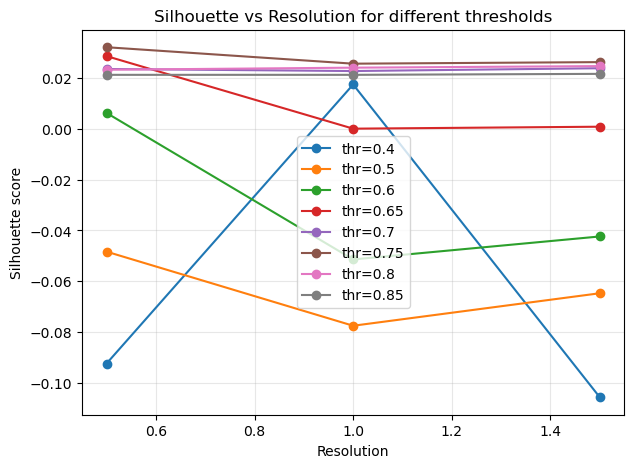

In [211]:
plt.figure(figsize=(7,5))
for thr in thresholds:
    sub = results_df[results_df["threshold"] == thr]
    sub_sorted = sub.sort_values("resolution")
    plt.plot(sub_sorted["resolution"], sub_sorted["silhouette"], marker="o", label=f"thr={thr}")
plt.xlabel("Resolution")
plt.ylabel("Silhouette score")
plt.title("Silhouette vs Resolution for different thresholds")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


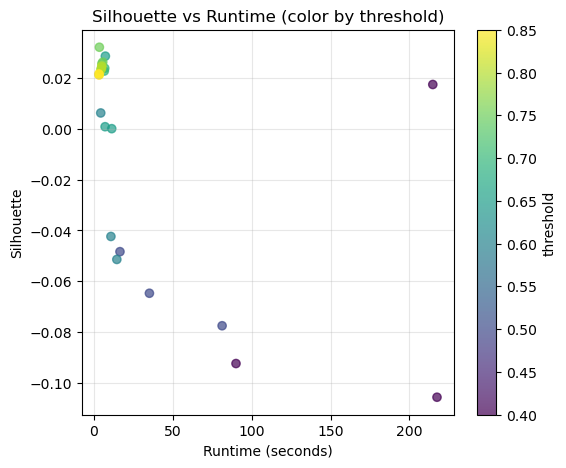

In [212]:
plt.figure(figsize=(6,5))
plt.scatter(results_df["runtime_sec"], results_df["silhouette"], c=results_df["threshold"], cmap="viridis", alpha=0.7)
plt.xlabel("Runtime (seconds)")
plt.ylabel("Silhouette")
plt.title("Silhouette vs Runtime (color by threshold)")
plt.colorbar(label="threshold")
plt.grid(True, alpha=0.3)
plt.show()

#### 3.2.5 Selection of best result based on custom made score

In [339]:
row = best_configs.iloc[0]
thr_best = row["threshold"]
res_best = row["resolution"]
seed_best = int(row["seed"])

print("Best config:", thr_best, res_best, seed_best)

# Get partition for that config
best_partition = partitions_cache[(thr_best, res_best, seed_best)]
labels_best = np.array([best_partition[i] for i in range(len(best_partition))])

Best config: 0.8 1.5 0


### 3.3 Analysis of the best Louvain

#### 3.3.1 Check the cluster sizes

In [340]:
cluster_sizes = Counter(best_partition.values())
print("Cluster size distribution:")

for cluster_id, size in cluster_sizes.most_common():
    print(f"Cluster {cluster_id}: {size} games")

Cluster size distribution:
Cluster 1315: 65 games
Cluster 190: 55 games
Cluster 69: 36 games
Cluster 593: 30 games
Cluster 787: 28 games
Cluster 414: 22 games
Cluster 2029: 22 games
Cluster 264: 21 games
Cluster 355: 21 games
Cluster 1658: 19 games
Cluster 185: 17 games
Cluster 196: 17 games
Cluster 169: 16 games
Cluster 1607: 16 games
Cluster 2855: 12 games
Cluster 3312: 11 games
Cluster 3891: 11 games
Cluster 130: 10 games
Cluster 225: 10 games
Cluster 4987: 10 games
Cluster 571: 9 games
Cluster 1411: 9 games
Cluster 686: 8 games
Cluster 2271: 8 games
Cluster 4733: 7 games
Cluster 427: 6 games
Cluster 1490: 6 games
Cluster 119: 5 games
Cluster 176: 5 games
Cluster 259: 5 games
Cluster 266: 5 games
Cluster 960: 5 games
Cluster 1259: 5 games
Cluster 2152: 5 games
Cluster 2325: 5 games
Cluster 2602: 5 games
Cluster 2982: 5 games
Cluster 3578: 5 games
Cluster 70: 4 games
Cluster 208: 4 games
Cluster 329: 4 games
Cluster 434: 4 games
Cluster 766: 4 games
Cluster 1040: 4 games
Cluster 1047

#### 3.3.2 Check average intra-cluster similarity

In [341]:
def average_intra_cluster_similarity(sim_matrix, partition):
    clusters = {}
    for node, cid in partition.items():
        clusters.setdefault(cid, []).append(node)

    intra_sims = {}

    for cid, nodes in clusters.items():
        if len(nodes) < 2:
            intra_sims[cid] = 0
            continue

        sims = []
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                sims.append(sim_matrix[nodes[i], nodes[j]])

        intra_sims[cid] = np.mean(sims)

    return intra_sims

In [342]:
intra = average_intra_cluster_similarity(sim_matrix, best_partition)

print("\nAverage intra-cluster similarity:")
for cid, sim in sorted(intra.items(), key=lambda x: -x[1])[:10]:
    print(f"Cluster {cid}: {sim:.4f}")


Average intra-cluster similarity:
Cluster 5985: 1.0000
Cluster 4831: 0.9995
Cluster 6743: 0.9930
Cluster 4999: 0.9877
Cluster 5035: 0.9876
Cluster 1490: 0.9840
Cluster 5754: 0.9819
Cluster 4841: 0.9806
Cluster 4408: 0.9774
Cluster 3625: 0.9715


#### 3.3.2 Plot of a scatter map of the comunities 

In [343]:
# This may take a while if there are many nodes
X_2d = TSNE(
    n_components=2,
    init="random",
    learning_rate="auto",
    perplexity=30,
    max_iter=1000,
    verbose=1,
    ).fit_transform(emb_norm)

def plot_partition_2d(labels, title=""):
    plt.figure(figsize=(7,6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, s=3, cmap="tab20")
    plt.title(title)
    plt.axis("off")
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10476 samples in 0.005s...
[t-SNE] Computed neighbors for 10476 samples in 1.369s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10476
[t-SNE] Computed conditional probabilities for sample 2000 / 10476
[t-SNE] Computed conditional probabilities for sample 3000 / 10476
[t-SNE] Computed conditional probabilities for sample 4000 / 10476
[t-SNE] Computed conditional probabilities for sample 5000 / 10476
[t-SNE] Computed conditional probabilities for sample 6000 / 10476
[t-SNE] Computed conditional probabilities for sample 7000 / 10476
[t-SNE] Computed conditional probabilities for sample 8000 / 10476
[t-SNE] Computed conditional probabilities for sample 9000 / 10476
[t-SNE] Computed conditional probabilities for sample 10000 / 10476
[t-SNE] Computed conditional probabilities for sample 10476 / 10476
[t-SNE] Mean sigma: 0.253180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 95.647697
[t-SNE] KL 

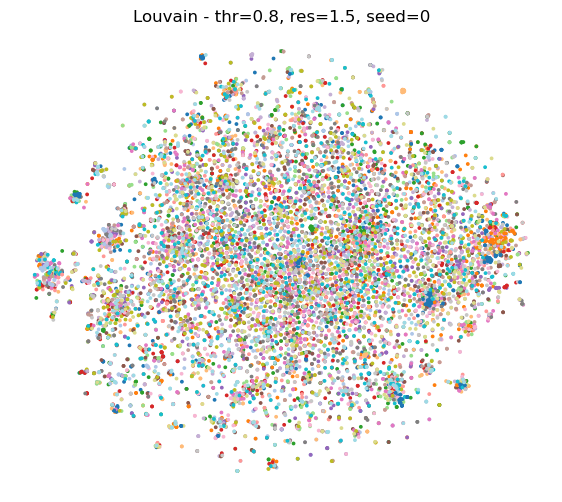

In [344]:
plot_partition_2d(labels_best, title=f"Louvain - thr={thr_best}, res={res_best}, seed={seed_best}")

##### 3.3.2.a Plot the top clusters

In [345]:
def plot_top_clusters(X_2d, labels, top_k=15, title="Louvain communities"):
    cluster_sizes = pd.Series(labels).value_counts()
    top_clusters = cluster_sizes.head(top_k).index

    # map top cluster ids -> 0..top_k-1
    color_map = {cid: i for i, cid in enumerate(top_clusters)}
    colors = np.full_like(labels, fill_value=-1, dtype=int)

    for cid in top_clusters:
        colors[labels == cid] = color_map[cid]

    plt.figure(figsize=(8, 7))
    # background: all points in light gray
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c="lightgray", s=2, alpha=0.2)

    # highlight: only top clusters
    mask = colors >= 0
    sc = plt.scatter(
        X_2d[mask, 0],
        X_2d[mask, 1],
        c=colors[mask],
        s=6,
        cmap="tab20",
        alpha=0.9,
    )
    plt.title(f"{title} (top {top_k} clusters)")
    plt.axis("off")
    plt.show()


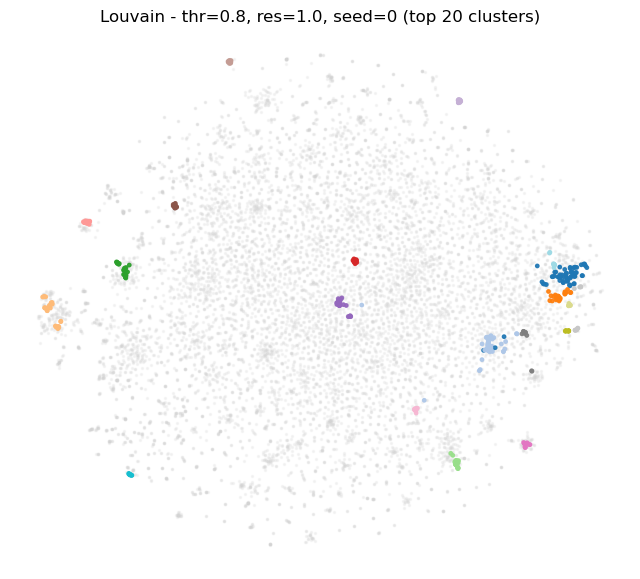

In [346]:
plot_top_clusters(X_2d, labels_best, top_k=20, title="Louvain - thr=0.8, res=1.0, seed=0")

##### 3.3.2.b Plot and inspect a single cluster

In [347]:
def plot_single_community(cluster_id, X_2d, labels, title_prefix="Cluster"):
    mask = labels == cluster_id

    plt.figure(figsize=(8, 7))
    # all nodes in light gray
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c="lightgray", s=2, alpha=0.2)
    # selected cluster in color
    plt.scatter(X_2d[mask, 0], X_2d[mask, 1], c="red", s=6, alpha=0.9)
    plt.title(f"{title_prefix} {cluster_id} (size={mask.sum()})")
    plt.axis("off")
    plt.show()

In [348]:
def inspect_cluster(cluster_id, df, partition, n=30):
    # node ids from Louvain partition
    node_ids = [i for i, c in partition.items() if c == cluster_id]

    # keep only ids that are valid row positions in df
    valid_ids = [i for i in node_ids if 0 <= i < len(df)]
    dropped = len(node_ids) - len(valid_ids)
    if dropped > 0:
        print(f"Warning: dropped {dropped} nodes not in [0, {len(df)-1}]")

    if not valid_ids:
        print(f"No nodes from cluster {cluster_id} are present in the current df.")
        return

    # now this can't be out-of-bounds
    df_cluster = df.iloc[valid_ids]

    print(f"Cluster {cluster_id} - size={len(df_cluster)}\n")

    # Top genres (adapt column name if needed)
    if "genres" in df_cluster.columns:
        print("Top genres:")
        print(df_cluster["genres"].value_counts().head(10))
        print()

    # Top platforms, if present
    for col in ["platforms", "platform", "main_platform"]:
        if col in df_cluster.columns:
            print(f"Top {col}:")
            print(df_cluster[col].value_counts().head(10))
            print()
            break

    print("Sample games:")
    cols = [c for c in ["game_id", "name", "genres"] if c in df_cluster.columns]
    display(df_cluster[cols].head(n))


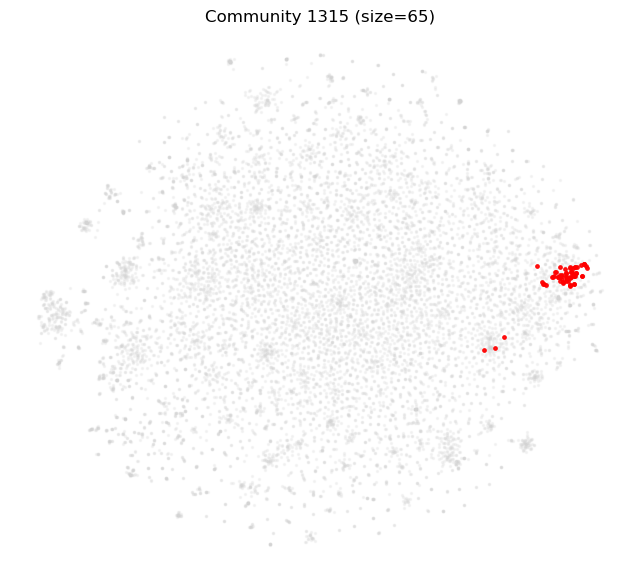

Cluster 1315 - size=65

Top genres:
genres
Indie                                              23
Indie, Puzzle                                       8
Indie, Strategy                                     7
Indie, Role-playing (RPG), Simulator                6
Puzzle                                              3
Indie, Simulator                                    3
Adventure, Indie, Simulator                         3
Simulator                                           3
Adventure, Indie, Role-playing (RPG), Simulator     2
Strategy                                            2
Name: count, dtype: int64

Top platforms:
platforms
PC (Microsoft Windows)                62
Linux, Mac, PC (Microsoft Windows)     2
Linux, PC (Microsoft Windows)          1
Name: count, dtype: int64

Sample games:


,game_id,name,genres
171,326234,Hentai World Halloween,Indie
1134,286442,Hentai Cosplay Elf,Indie
1284,311810,Hentai Girls Nature,Indie
1348,340464,Hentai World Winter,Indie
1370,349956,Hentai World Bunny,Indie
1686,241386,Hentai Pool,"Indie, Strategy"
1710,163535,Hentai Girls 18+,"Indie, Simulator"
1885,286739,Easy Hentai Puzzle 2,"Indie, Puzzle"
2046,271032,Hentai Ancient Secret,Indie
2124,171664,Hentai Princess,"Adventure, Indie, Role-playing (RPG), Simulator"


In [349]:
cluster_sizes = pd.Series(labels_best).value_counts()

cluster_id = int(cluster_sizes.index[0])  # largest cluster, for example
plot_single_community(cluster_id, X_2d, labels_best, title_prefix="Community")
inspect_cluster(cluster_id, games_df, best_partition)


#### 3.3.3 Check the top genres of the clusters

In [350]:
def cluster_top_genre(df, labels, max_clusters=50):
    df_tmp = df.copy()
    df_tmp["cluster"] = labels

    rows = []
    for cid, grp in df_tmp.groupby("cluster"):
        if len(rows) >= max_clusters:
            break
        if "genres" not in grp.columns:
            continue
        top_genre = grp["genres"].value_counts().idxmax()
        genre_share = grp["genres"].value_counts(normalize=True).iloc[0]
        rows.append({
            "cluster": cid,
            "size": len(grp),
            "top_genre": top_genre,
            "top_genre_share": genre_share,
        })

    return pd.DataFrame(rows).sort_values("size", ascending=False)

top_genres_per_cluster = cluster_top_genre(games_df, labels_best, max_clusters=len(np.unique(labels_best)))
top_genres_per_cluster.head(10)


,cluster,size,top_genre,top_genre_share
1315,1315,65,Indie,0.353846
190,190,55,Indie,0.763636
69,69,36,Indie,0.638889
593,593,30,Simulator,1.000000
787,787,28,Simulator,1.000000
414,414,22,Indie,0.409091
2029,2029,22,"Adventure, Indie, Racing, Role-playing (RPG), ...",0.863636
355,355,21,"Adventure, Role-playing (RPG)",0.333333
264,264,21,Fighting,0.428571
1658,1658,19,"Adventure, Role-playing (RPG), Simulator, Stra...",0.789474


### 3.4 Recommender with the best Louvain

In [351]:
_partition_cache = None
_graph_cache = None

def louvain_recommender(game_id, embeddings_norm, topk=10):

    global _partition_cache, _graph_cache

    # Load partition
    if _partition_cache is None:
        print("Loading Louvain partition...")
        with open("partition_louvain_puro.pkl", "rb") as f:
            _partition_cache = pickle.load(f)

    # Load graph
    if _graph_cache is None:
        print("Loading Louvain graph...")
        with open("graph_louvain_puro.pkl", "rb") as f:
            _graph_cache = pickle.load(f)

    partition = _partition_cache
    G = _graph_cache
    cluster_id = partition[game_id]
    same_cluster = [
        j for j, c in partition.items()
        if c == cluster_id and j != game_id
    ]

    if len(same_cluster) == 0:
        print("Game is isolated; no recommendations.")
        return []

    sims = [
        (j, float(np.dot(embeddings_norm[game_id], embeddings_norm[j])))
        for j in same_cluster
    ]

    sims.sort(key=lambda x: x[1], reverse=True)
    return sims[:topk]

In [363]:
nodes_in_top = np.where(labels_best == cluster_id)[0].tolist()
random_node = random.choice(nodes_in_top)

base_row = games_df.iloc[random_node]
game_id = int(base_row["game_id"])
print(f"Base game: {base_row['name']} (game_id={game_id}):")

# pass the node index to the recommender so it matches the partition keys
recs = louvain_recommender(random_node, emb_norm)
for idx, sim in recs:
    print(f"  {games_df.iloc[idx]['name']} - similarity = {sim:.3f}")

Base game: Hentai Girls Nature (game_id=311810):
  Hentai Girls - similarity = 0.889
  Hentai Two Girls - similarity = 0.835
  Hentai World Winter - similarity = 0.832
  Hentai Journey - similarity = 0.829
  Hentai World Halloween - similarity = 0.820
  Hentai Girls Maid - similarity = 0.805
  Hentai: Ultimate Puzzle - similarity = 0.804
  Easy Hentai Puzzle 2 - similarity = 0.803
  Hentai Cool Girls - similarity = 0.802
  Hentai Crazy Girls - similarity = 0.801
